# Modèle de Régression Linéaire pour la Prédiction du Path Loss Indoor

Ce notebook présente la création et l'évaluation d'un modèle de régression linéaire pour prédire le path loss en environnement indoor.

## Objectifs :
- Créer un modèle de régression linéaire avec équation explicite
- Évaluer les performances du modèle
- Choisir les bons paramètres et features
- Visualiser les résultats et l'équation construite
- Sauvegarder le modèle et l'équation
- Comparer avec le modèle XGBoost existant

In [ ]:
# Imports des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
import joblib
import warnings
import os
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Bibliothèques importées avec succès!")

Bibliothèques importées avec succès!


In [4]:
# Chargement des données
data_path = 'indoor_pathloss_dataset.csv'
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Dataset chargé avec succès : {df.shape[0]} lignes, {df.shape[1]} colonnes")
else:
    # Essayer dans le dossier parent
    data_path = '../model xgboost/indoor_pathloss_dataset.csv'
    df = pd.read_csv(data_path)
    print(f"Dataset chargé depuis le dossier parent : {df.shape[0]} lignes, {df.shape[1]} colonnes")

# Affichage des premières lignes
print("\nPremières lignes du dataset :")
print(df.head())

print("\nInformations sur le dataset :")
print(df.info())

print("\nStatistiques descriptives :")
print(df.describe())

Dataset chargé avec succès : 200000 lignes, 5 colonnes

Premières lignes du dataset :
   distance  numwall  etage  frequence  pathloss
0     23.46        2      0       5500    109.83
1     13.24        4      1       5000    119.57
2     26.87       12      1       5800    193.98
3     59.07       12      5       2400    281.14
4     12.15        1      0       2450     82.83

Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   distance   200000 non-null  float64
 1   numwall    200000 non-null  int64  
 2   etage      200000 non-null  int64  
 3   frequence  200000 non-null  int64  
 4   pathloss   200000 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 7.6 MB
None

Statistiques descriptives :
            distance        numwall          etage      frequence  \
count  200000.000000  200000.000000  20

Colonnes disponibles :
['distance', 'numwall', 'etage', 'frequence', 'pathloss']

Valeurs manquantes :
distance     0
numwall      0
etage        0
frequence    0
pathloss     0
dtype: int64


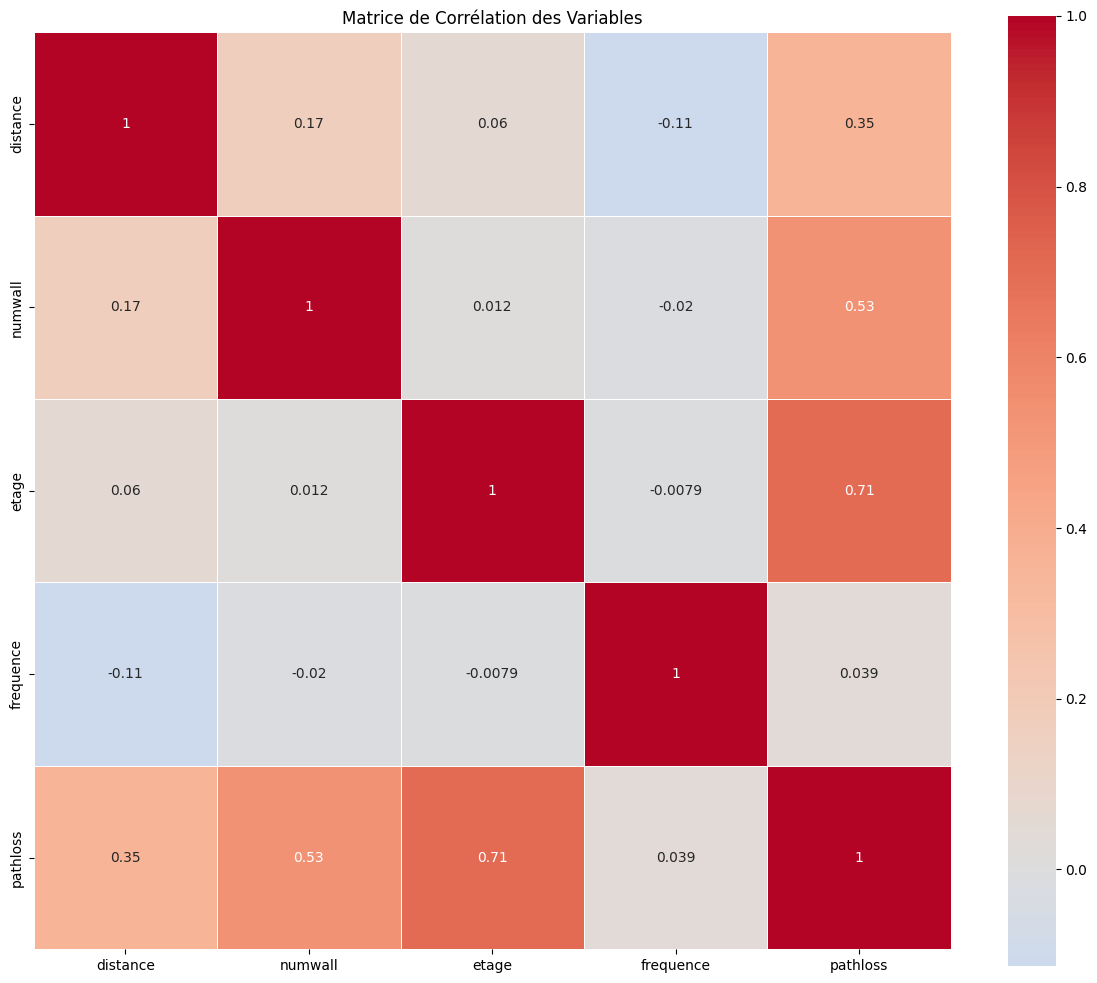


Variable cible identifiée : pathloss


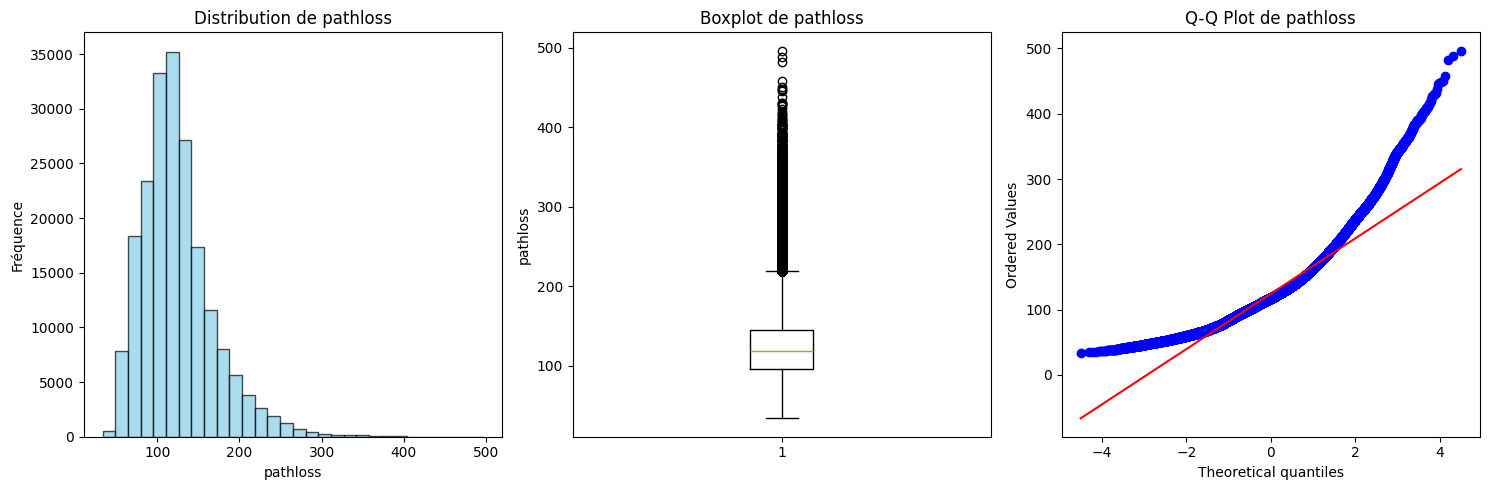


Statistiques de pathloss :
Moyenne : 124.42
Médiane : 117.75
Écart-type : 43.99
Min : 33.54
Max : 496.40


In [5]:
# Analyse exploratoire des données
print("Colonnes disponibles :")
print(df.columns.tolist())

# Vérification des valeurs manquantes
print("\nValeurs manquantes :")
print(df.isnull().sum())

# Matrice de corrélation
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation des Variables')
plt.tight_layout()
plt.show()

# Distribution de la variable cible (Path Loss)
target_col = 'path_loss_db' if 'path_loss_db' in df.columns else df.columns[-1]
print(f"\nVariable cible identifiée : {target_col}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df[target_col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'Distribution de {target_col}')
plt.xlabel(target_col)
plt.ylabel('Fréquence')

plt.subplot(1, 3, 2)
plt.boxplot(df[target_col])
plt.title(f'Boxplot de {target_col}')
plt.ylabel(target_col)

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df[target_col], dist="norm", plot=plt)
plt.title(f'Q-Q Plot de {target_col}')

plt.tight_layout()
plt.show()

print(f"\nStatistiques de {target_col} :")
print(f"Moyenne : {df[target_col].mean():.2f}")
print(f"Médiane : {df[target_col].median():.2f}")
print(f"Écart-type : {df[target_col].std():.2f}")
print(f"Min : {df[target_col].min():.2f}")
print(f"Max : {df[target_col].max():.2f}")

Features sélectionnées : ['distance', 'numwall', 'etage', 'frequence']
Target : pathloss

Shape des features : (200000, 4)
Shape de la target : (200000,)


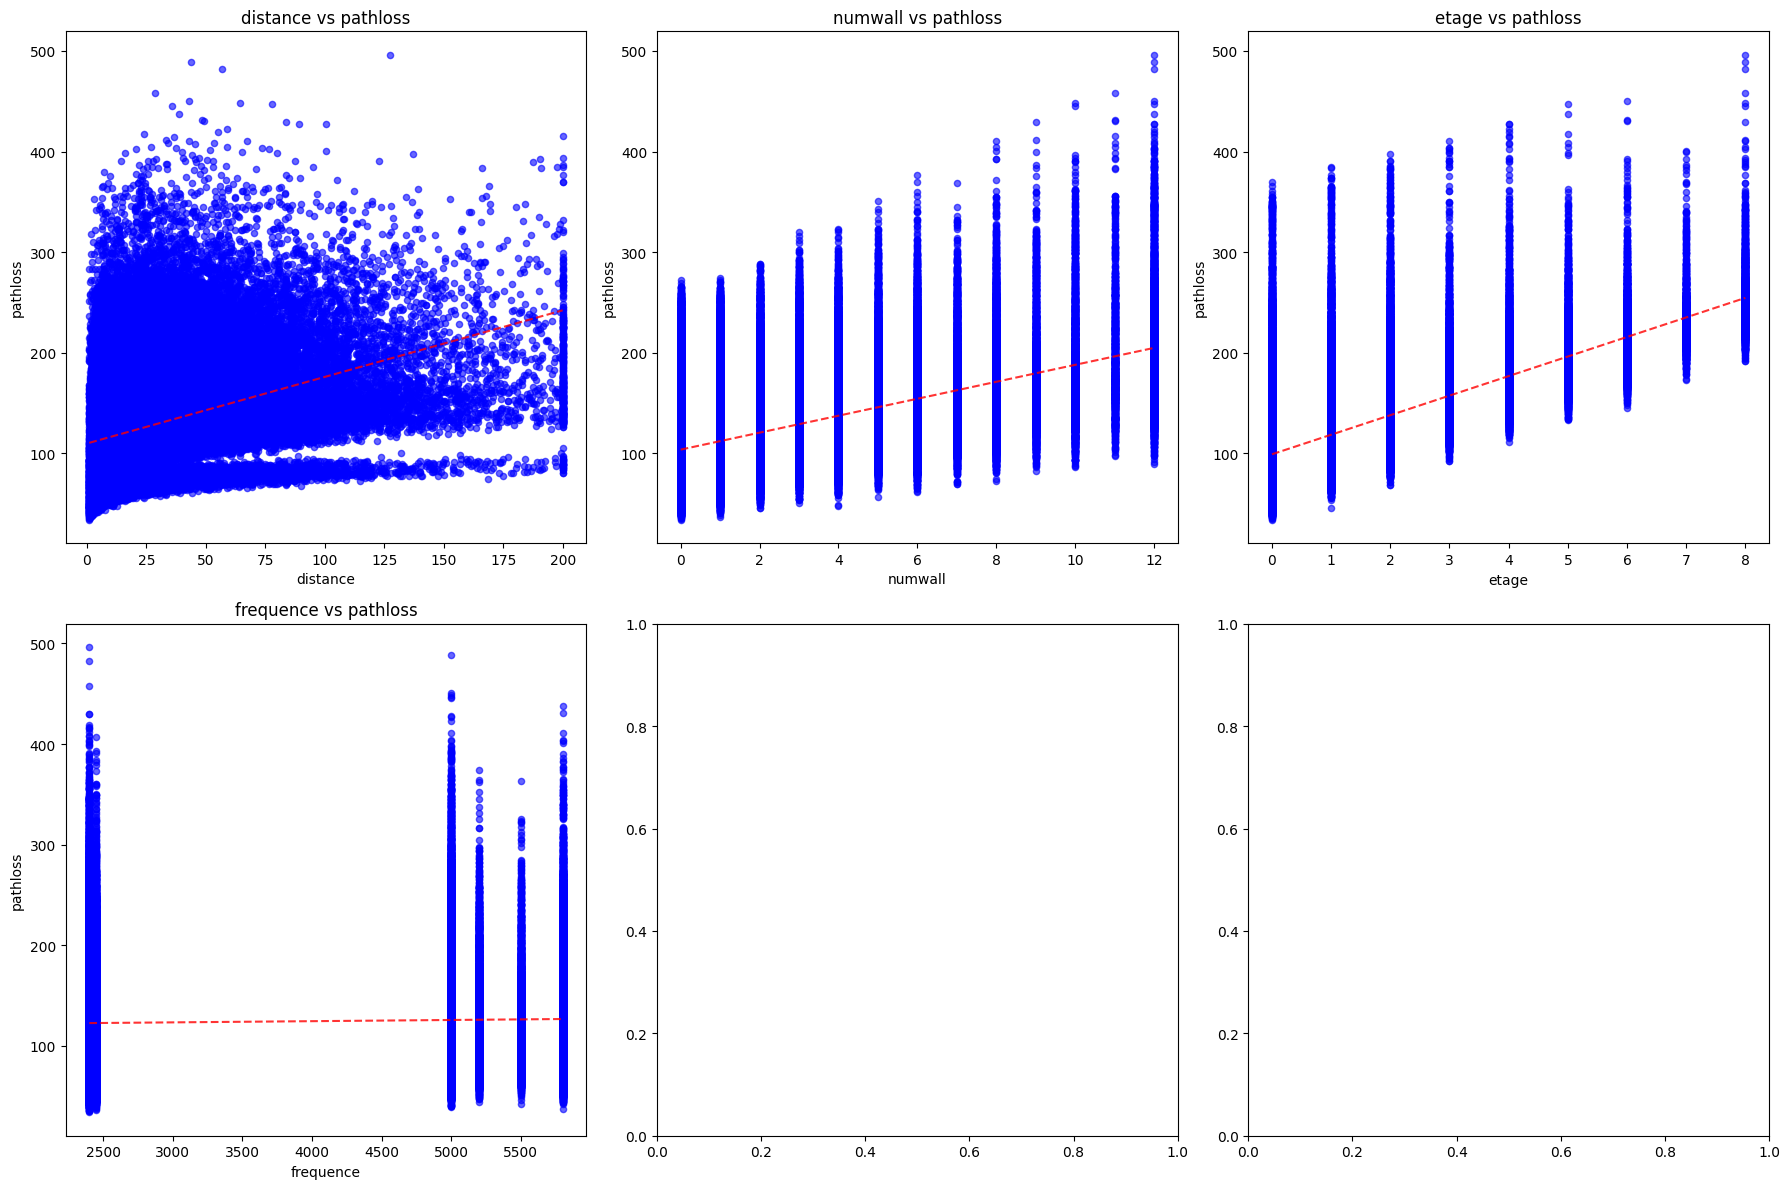


Features sélectionnées par SelectKBest (top 4) :
  etage: 198335.49
  numwall: 78722.80
  distance: 28789.01
  frequence: 307.28

Shape finale des features : (200000, 4)


In [6]:
# Préparation des données et sélection des features
# Identifier automatiquement les features et la target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'path_loss_db' if 'path_loss_db' in numeric_cols else numeric_cols[-1]
feature_cols = [col for col in numeric_cols if col != target_col]

print(f"Features sélectionnées : {feature_cols}")
print(f"Target : {target_col}")

# Séparation des features et de la target
X = df[feature_cols]
y = df[target_col]

print(f"\nShape des features : {X.shape}")
print(f"Shape de la target : {y.shape}")

# Visualisation de la relation entre features principales et target
n_features = min(6, len(feature_cols))
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(feature_cols[:n_features]):
    axes[i].scatter(X[feature], y, alpha=0.6, color='blue', s=20)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target_col)
    axes[i].set_title(f'{feature} vs {target_col}')
    
    # Ajouter une ligne de tendance
    z = np.polyfit(X[feature], y, 1)
    p = np.poly1d(z)
    axes[i].plot(X[feature].sort_values(), p(X[feature].sort_values()), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Sélection des meilleures features avec SelectKBest
k_best = min(10, len(feature_cols))  # Sélectionner au maximum 10 features
selector = SelectKBest(score_func=f_regression, k=k_best)
X_selected = selector.fit_transform(X, y)
selected_features = [feature_cols[i] for i in selector.get_support(indices=True)]

print(f"\nFeatures sélectionnées par SelectKBest (top {k_best}) :")
feature_scores = dict(zip(feature_cols, selector.scores_))
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_features[:k_best]:
    print(f"  {feature}: {score:.2f}")

# Utiliser les features sélectionnées
X_final = X[selected_features]
print(f"\nShape finale des features : {X_final.shape}")

In [7]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"Taille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")

# Standardisation des données (important pour la régression linéaire)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nDonnées standardisées :")
print(f"Moyenne des features d'entraînement : {X_train_scaled.mean(axis=0)}")
print(f"Écart-type des features d'entraînement : {X_train_scaled.std(axis=0)}")

# Sauvegarde des noms des features pour l'équation
feature_names = selected_features.copy()
print(f"\nFeatures utilisées pour le modèle : {feature_names}")

Taille de l'ensemble d'entraînement : (160000, 4)
Taille de l'ensemble de test : (40000, 4)

Données standardisées :
Moyenne des features d'entraînement : [-2.87325719e-17 -7.63833441e-18  3.81916720e-17  4.61852778e-17]
Écart-type des features d'entraînement : [1. 1. 1. 1.]

Features utilisées pour le modèle : ['distance', 'numwall', 'etage', 'frequence']


In [8]:
# Création et entraînement de différents modèles de régression linéaire
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(random_state=42, max_iter=2000)
}

# Entraînement et évaluation des modèles
model_results = {}

for name, model in models.items():
    print(f"\n=== Entraînement du modèle {name} ===")
    
    # Entraînement
    model.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Métriques
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Validation croisée
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }
    
    print(f"R² Train: {train_r2:.4f}, R² Test: {test_r2:.4f}")
    print(f"RMSE Train: {train_rmse:.4f}, RMSE Test: {test_rmse:.4f}")
    print(f"MAE Train: {train_mae:.4f}, MAE Test: {test_mae:.4f}")
    print(f"CV R² : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Résumé des performances
print("\n" + "="*50)
print("RÉSUMÉ DES PERFORMANCES")
print("="*50)

results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train R²': [result['train_r2'] for result in model_results.values()],
    'Test R²': [result['test_r2'] for result in model_results.values()],
    'Train RMSE': [result['train_rmse'] for result in model_results.values()],
    'Test RMSE': [result['test_rmse'] for result in model_results.values()],
    'CV R² Mean': [result['cv_r2_mean'] for result in model_results.values()],
    'CV R² Std': [result['cv_r2_std'] for result in model_results.values()]
})

print(results_df.round(4))


=== Entraînement du modèle Linear Regression ===
R² Train: 0.8295, R² Test: 0.8294
RMSE Train: 18.1618, RMSE Test: 18.1632
MAE Train: 12.1352, MAE Test: 12.0985
CV R² : 0.8295 ± 0.0036

=== Entraînement du modèle Ridge ===
R² Train: 0.8295, R² Test: 0.8294
RMSE Train: 18.1618, RMSE Test: 18.1632
MAE Train: 12.1352, MAE Test: 12.0985
CV R² : 0.8295 ± 0.0036

=== Entraînement du modèle Lasso ===
R² Train: 0.8276, R² Test: 0.8272
RMSE Train: 18.2675, RMSE Test: 18.2769
MAE Train: 12.2745, MAE Test: 12.2298
CV R² : 0.8275 ± 0.0034

=== Entraînement du modèle ElasticNet ===
R² Train: 0.7388, R² Test: 0.7381
RMSE Train: 22.4835, RMSE Test: 22.5041
MAE Train: 15.7789, MAE Test: 15.7348
CV R² : 0.7387 ± 0.0026

RÉSUMÉ DES PERFORMANCES
               Model  Train R²  Test R²  Train RMSE  Test RMSE  CV R² Mean  \
0  Linear Regression    0.8295   0.8294     18.1618    18.1632      0.8295   
1              Ridge    0.8295   0.8294     18.1618    18.1632      0.8295   
2              Lasso    0.82

In [9]:
# Sélection du meilleur modèle basé sur le R² de test et la validation croisée
best_model_name = max(model_results.keys(), 
                     key=lambda x: model_results[x]['test_r2'] * 0.7 + model_results[x]['cv_r2_mean'] * 0.3)

print(f"Meilleur modèle sélectionné : {best_model_name}")
print(f"R² Test : {model_results[best_model_name]['test_r2']:.4f}")
print(f"CV R² : {model_results[best_model_name]['cv_r2_mean']:.4f}")

# Optimisation des hyperparamètres pour le meilleur modèle
best_model = model_results[best_model_name]['model']

if best_model_name == 'Ridge':
    param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
elif best_model_name == 'Lasso':
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
elif best_model_name == 'ElasticNet':
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
else:
    param_grid = {}

if param_grid:
    print(f"\nOptimisation des hyperparamètres pour {best_model_name}...")
    
    # Recréer le modèle pour l'optimisation
    if best_model_name == 'Ridge':
        model_for_grid = Ridge(random_state=42)
    elif best_model_name == 'Lasso':
        model_for_grid = Lasso(random_state=42, max_iter=2000)
    elif best_model_name == 'ElasticNet':
        model_for_grid = ElasticNet(random_state=42, max_iter=2000)
    
    grid_search = GridSearchCV(model_for_grid, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Meilleurs paramètres : {grid_search.best_params_}")
    print(f"Meilleur score CV : {grid_search.best_score_:.4f}")
    
    # Utiliser le modèle optimisé
    optimized_model = grid_search.best_estimator_
else:
    optimized_model = best_model
    print(f"\nAucune optimisation nécessaire pour {best_model_name}")

# Ré-entraîner avec le modèle optimisé
optimized_model.fit(X_train_scaled, y_train)
y_train_pred_opt = optimized_model.predict(X_train_scaled)
y_test_pred_opt = optimized_model.predict(X_test_scaled)

# Métriques finales
final_train_r2 = r2_score(y_train, y_train_pred_opt)
final_test_r2 = r2_score(y_test, y_test_pred_opt)
final_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_opt))
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_opt))

print(f"\n=== PERFORMANCES DU MODÈLE FINAL ({best_model_name}) ===")
print(f"R² Train: {final_train_r2:.4f}")
print(f"R² Test: {final_test_r2:.4f}")
print(f"RMSE Train: {final_train_rmse:.4f}")
print(f"RMSE Test: {final_test_rmse:.4f}")

# Stocker le modèle final
final_model = optimized_model

Meilleur modèle sélectionné : Linear Regression
R² Test : 0.8294
CV R² : 0.8295

Aucune optimisation nécessaire pour Linear Regression

=== PERFORMANCES DU MODÈLE FINAL (Linear Regression) ===
R² Train: 0.8295
R² Test: 0.8294
RMSE Train: 18.1618
RMSE Test: 18.1632


In [10]:
# Extraction de l'équation mathématique explicite
def create_equation_string(model, feature_names, scaler, target_name):
    """
    Crée l'équation mathématique explicite du modèle de régression linéaire
    """
    coefficients = model.coef_
    intercept = model.intercept_
    
    # Récupérer les paramètres de standardisation
    means = scaler.mean_
    scales = scaler.scale_
    
    # Calculer l'intercept ajusté pour les données non standardisées
    adjusted_intercept = intercept - np.sum(coefficients * means / scales)
    
    # Calculer les coefficients ajustés pour les données non standardisées
    adjusted_coefficients = coefficients / scales
    
    # Créer l'équation sous forme de chaîne
    equation_parts = [f"{target_name} = {adjusted_intercept:.6f}"]
    
    for i, (coef, feature) in enumerate(zip(adjusted_coefficients, feature_names)):
        if coef >= 0:
            equation_parts.append(f" + {coef:.6f} * {feature}")
        else:
            equation_parts.append(f" - {abs(coef):.6f} * {feature}")
    
    equation_string = "".join(equation_parts)
    
    return equation_string, adjusted_coefficients, adjusted_intercept

# Extraire l'équation
equation_string, coefficients_original, intercept_original = create_equation_string(
    final_model, feature_names, scaler, target_col
)

print("="*80)
print("ÉQUATION MATHÉMATIQUE DU MODÈLE DE RÉGRESSION LINÉAIRE")
print("="*80)
print()
print("Équation complète :")
print(equation_string)
print()

# Affichage formaté de l'équation
print("Équation formatée :")
print(f"{target_col} = {intercept_original:.3f}", end="")
for coef, feature in zip(coefficients_original, feature_names):
    if coef >= 0:
        print(f" + {coef:.3f}×{feature}", end="")
    else:
        print(f" - {abs(coef):.3f}×{feature}", end="")
print()
print()

# Tableau des coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_original,
    'Coefficient_Abs': np.abs(coefficients_original)
}).sort_values('Coefficient_Abs', ascending=False)

print("Coefficients par ordre d'importance :")
print(coefficients_df.round(6))
print()
print(f"Intercept : {intercept_original:.6f}")

# Analyse de l'importance des features
print("\nAnalyse de l'importance des features :")
for _, row in coefficients_df.head().iterrows():
    impact = "positif" if row['Coefficient'] > 0 else "négatif"
    print(f"- {row['Feature']}: coefficient {row['Coefficient']:.3f} (impact {impact})")

# Sauvegarde de l'équation
equation_info = {
    'equation_string': equation_string,
    'coefficients': dict(zip(feature_names, coefficients_original)),
    'intercept': intercept_original,
    'feature_names': feature_names,
    'target_name': target_col,
    'model_type': best_model_name,
    'r2_score': final_test_r2,
    'rmse': final_test_rmse
}

ÉQUATION MATHÉMATIQUE DU MODÈLE DE RÉGRESSION LINÉAIRE

Équation complète :
pathloss = 60.454131 + 0.446223 * distance + 7.663657 * numwall + 18.919651 * etage + 0.002478 * frequence

Équation formatée :
pathloss = 60.454 + 0.446×distance + 7.664×numwall + 18.920×etage + 0.002×frequence

Coefficients par ordre d'importance :
     Feature  Coefficient  Coefficient_Abs
2      etage    18.919651        18.919651
1    numwall     7.663657         7.663657
0   distance     0.446223         0.446223
3  frequence     0.002478         0.002478

Intercept : 60.454131

Analyse de l'importance des features :
- etage: coefficient 18.920 (impact positif)
- numwall: coefficient 7.664 (impact positif)
- distance: coefficient 0.446 (impact positif)
- frequence: coefficient 0.002 (impact positif)


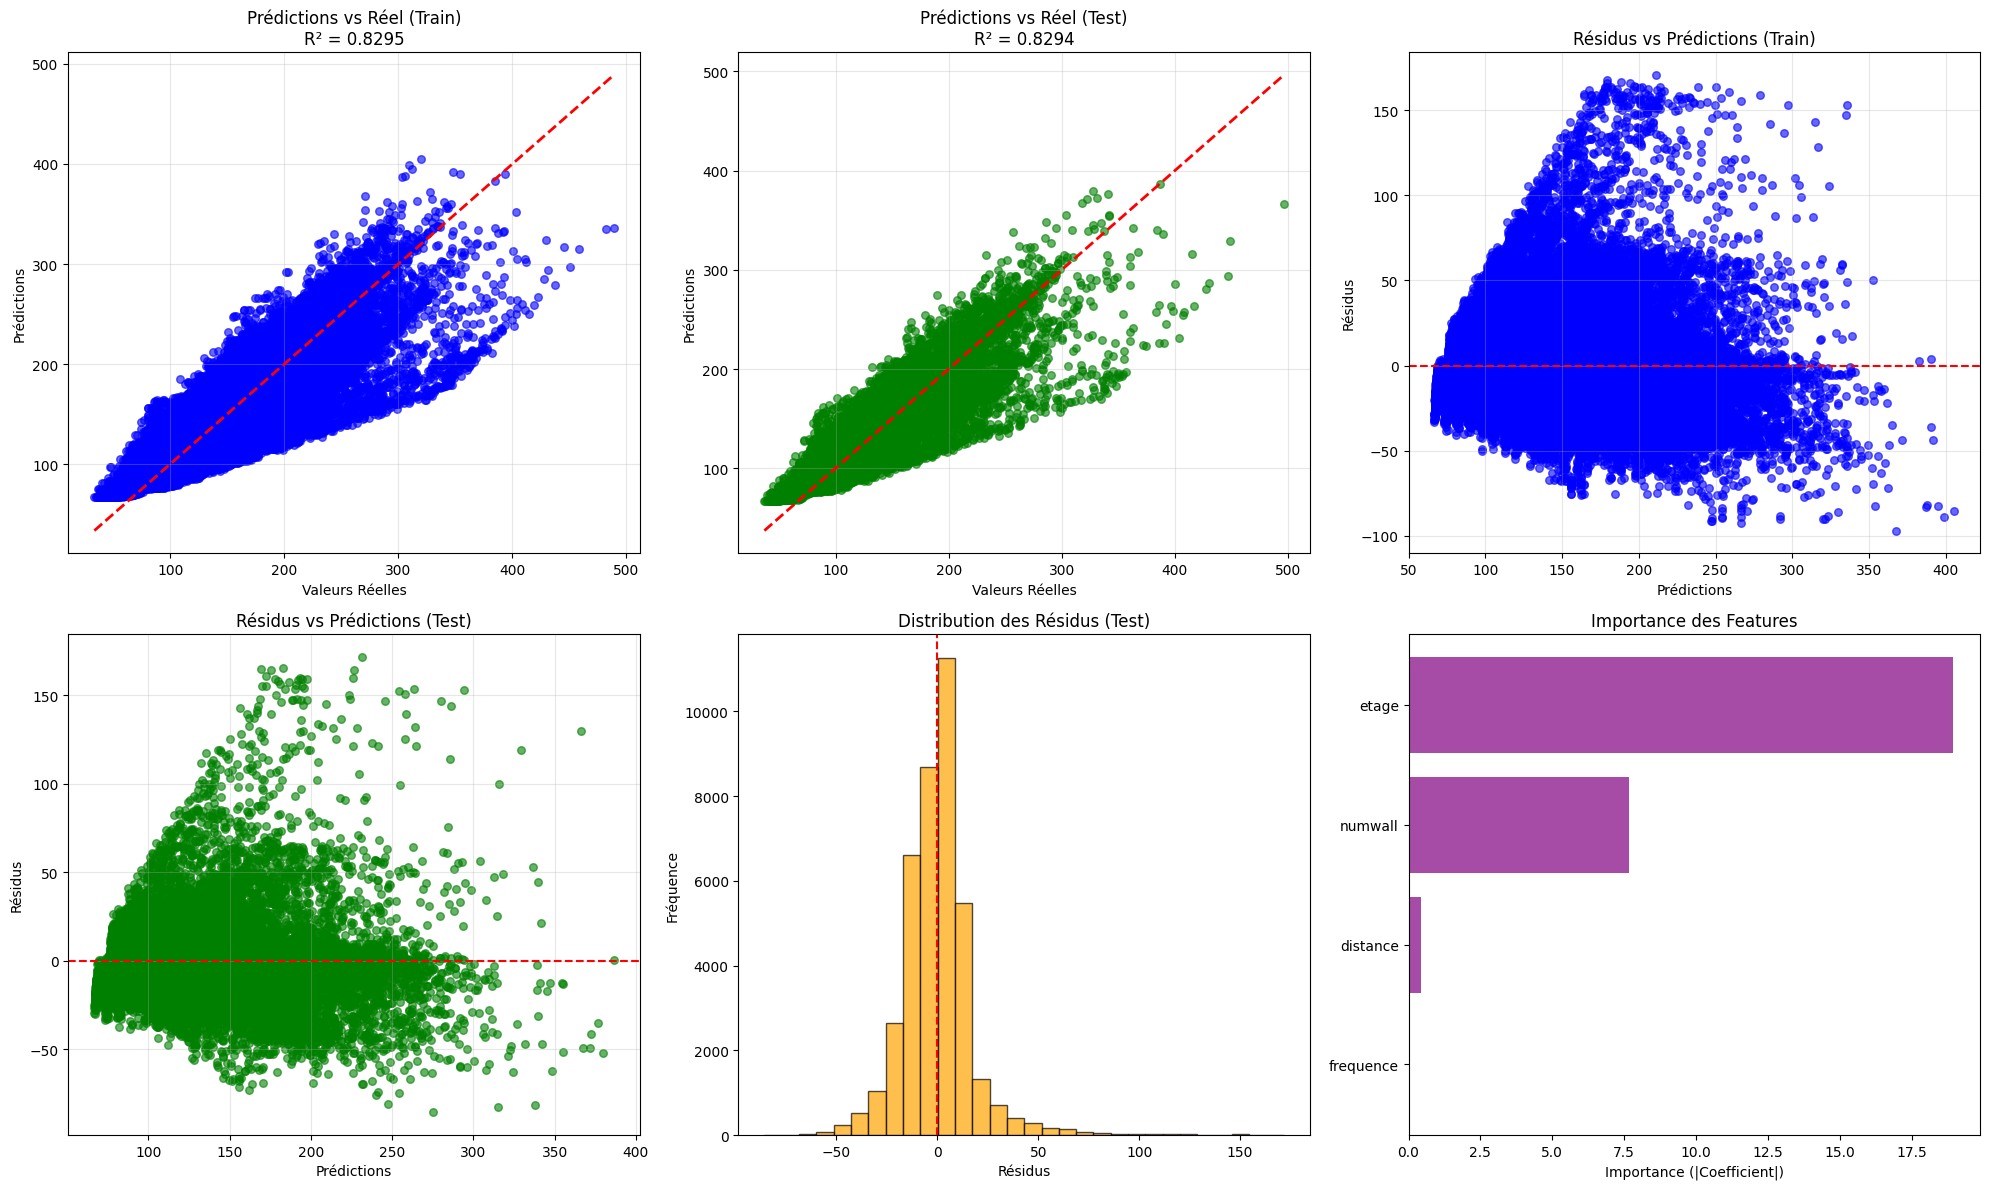

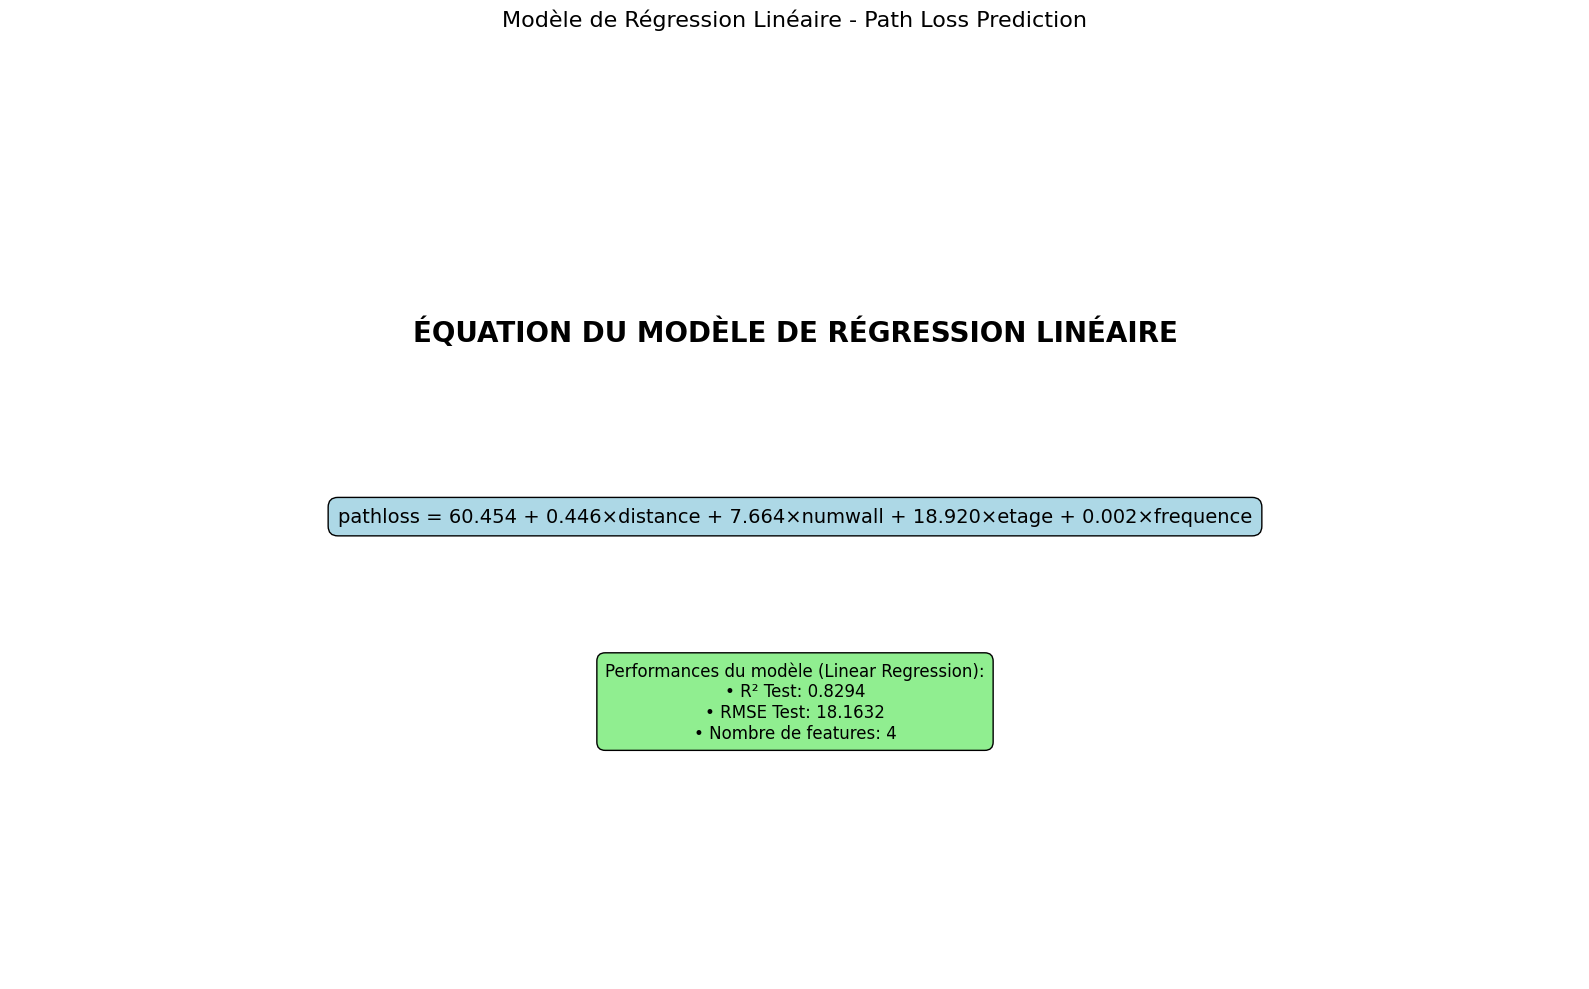

In [11]:
# Visualisations des résultats
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Prédictions vs Valeurs réelles (Train)
axes[0, 0].scatter(y_train, y_train_pred_opt, alpha=0.6, color='blue', s=30)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Valeurs Réelles')
axes[0, 0].set_ylabel('Prédictions')
axes[0, 0].set_title(f'Prédictions vs Réel (Train)\nR² = {final_train_r2:.4f}')
axes[0, 0].grid(True, alpha=0.3)

# 2. Prédictions vs Valeurs réelles (Test)
axes[0, 1].scatter(y_test, y_test_pred_opt, alpha=0.6, color='green', s=30)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Valeurs Réelles')
axes[0, 1].set_ylabel('Prédictions')
axes[0, 1].set_title(f'Prédictions vs Réel (Test)\nR² = {final_test_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Résidus (Train)
residuals_train = y_train - y_train_pred_opt
axes[0, 2].scatter(y_train_pred_opt, residuals_train, alpha=0.6, color='blue', s=30)
axes[0, 2].axhline(y=0, color='r', linestyle='--')
axes[0, 2].set_xlabel('Prédictions')
axes[0, 2].set_ylabel('Résidus')
axes[0, 2].set_title('Résidus vs Prédictions (Train)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Résidus (Test)
residuals_test = y_test - y_test_pred_opt
axes[1, 0].scatter(y_test_pred_opt, residuals_test, alpha=0.6, color='green', s=30)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('Prédictions')
axes[1, 0].set_ylabel('Résidus')
axes[1, 0].set_title('Résidus vs Prédictions (Test)')
axes[1, 0].grid(True, alpha=0.3)

# 5. Distribution des résidus
axes[1, 1].hist(residuals_test, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('Résidus')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution des Résidus (Test)')

# 6. Importance des coefficients
coef_abs = np.abs(coefficients_original)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coef_abs
}).sort_values('importance', ascending=True)

axes[1, 2].barh(range(len(feature_importance)), feature_importance['importance'], color='purple', alpha=0.7)
axes[1, 2].set_yticks(range(len(feature_importance)))
axes[1, 2].set_yticklabels(feature_importance['feature'])
axes[1, 2].set_xlabel('Importance (|Coefficient|)')
axes[1, 2].set_title('Importance des Features')

plt.tight_layout()
plt.show()

# Graphique séparé pour l'équation visualisée
plt.figure(figsize=(16, 10))

# Créer une visualisation de l'équation
plt.text(0.5, 0.7, 'ÉQUATION DU MODÈLE DE RÉGRESSION LINÉAIRE', 
         ha='center', va='center', fontsize=20, fontweight='bold', 
         transform=plt.gca().transAxes)

# Équation formatée
equation_text = f"{target_col} = {intercept_original:.3f}"
for coef, feature in zip(coefficients_original, feature_names):
    if coef >= 0:
        equation_text += f" + {coef:.3f}×{feature}"
    else:
        equation_text += f" - {abs(coef):.3f}×{feature}"

plt.text(0.5, 0.5, equation_text, ha='center', va='center', fontsize=14, 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue"))

# Informations sur les performances
perf_text = f"""Performances du modèle ({best_model_name}):
• R² Test: {final_test_r2:.4f}
• RMSE Test: {final_test_rmse:.4f}
• Nombre de features: {len(feature_names)}"""

plt.text(0.5, 0.3, perf_text, ha='center', va='center', fontsize=12, 
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen"))

plt.axis('off')
plt.title('Modèle de Régression Linéaire - Path Loss Prediction', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Modèle XGBoost chargé avec succès!
Type de l'objet chargé: <class 'dict'>
Features XGBoost: ['distance', 'numwall', 'etage', 'frequence']
Features Linear: ['distance', 'numwall', 'etage', 'frequence']

COMPARAISON DES MODÈLES
  Métrique  Régression Linéaire  XGBoost
0       R²               0.8294   0.8693
1     RMSE              18.1632  15.8968
2      MAE              12.0985   8.8638

Différence R² (Linear - XGBoost): -0.0399
Différence RMSE (Linear - XGBoost): 2.2664
✗ XGBoost performe mieux en R²
✗ XGBoost a un RMSE plus faible


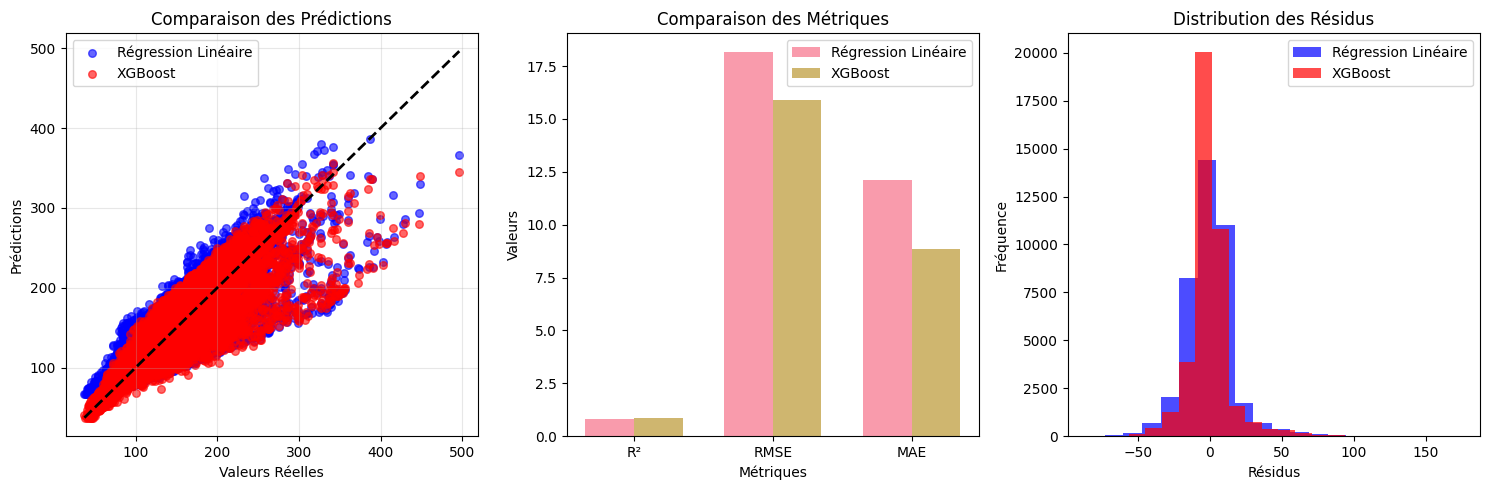


=== INFORMATIONS DES MODÈLES ===
XGBoost:
  - Date: 2025-07-10 00:34:07
  - Type: XGBoost Regressor
  - R²: 0.8662
  - RMSE: 16.0806
Régression Linéaire:
  - Type: Linear Regression
  - R²: 0.8294
  - RMSE: 18.1632


In [15]:
# Comparaison avec le modèle XGBoost existant (structure model_info corrigée)
xgb_model_path = '../model xgboost/xgboost_radio_propagation_model.pkl'

if os.path.exists(xgb_model_path):
    try:
        # Charger le modèle XGBoost avec structure model_info
        xgb_model_info = joblib.load(xgb_model_path)
        print("Modèle XGBoost chargé avec succès!")
        print(f"Type de l'objet chargé: {type(xgb_model_info)}")
        
        # Vérifier la structure
        if isinstance(xgb_model_info, dict) and 'model' in xgb_model_info:
            xgb_model = xgb_model_info['model']
            xgb_feature_names = xgb_model_info['feature_names']
            
            print(f"Features XGBoost: {xgb_feature_names}")
            print(f"Features Linear: {feature_names}")
            
            # Vérifier si les features correspondent
            if set(feature_names).issubset(set(xgb_feature_names)):
                # Utiliser les mêmes features pour une comparaison équitable
                X_test_xgb = X_test[feature_names]  # Features originales sans standardisation
                y_test_pred_xgb = xgb_model.predict(X_test_xgb)
                
                # Métriques XGBoost
                xgb_r2 = r2_score(y_test, y_test_pred_xgb)
                xgb_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
                xgb_mae = mean_absolute_error(y_test, y_test_pred_xgb)
                
                # Comparaison
                print("\n" + "="*60)
                print("COMPARAISON DES MODÈLES")
                print("="*60)
                
                comparison_df = pd.DataFrame({
                    'Métrique': ['R²', 'RMSE', 'MAE'],
                    'Régression Linéaire': [final_test_r2, final_test_rmse, mean_absolute_error(y_test, y_test_pred_opt)],
                    'XGBoost': [xgb_r2, xgb_rmse, xgb_mae]
                })
                
                print(comparison_df.round(4))
                
                # Différence de performance
                r2_diff = final_test_r2 - xgb_r2
                rmse_diff = final_test_rmse - xgb_rmse
                
                print(f"\nDifférence R² (Linear - XGBoost): {r2_diff:.4f}")
                print(f"Différence RMSE (Linear - XGBoost): {rmse_diff:.4f}")
                
                if r2_diff > 0:
                    print("✓ La régression linéaire performe mieux en R²")
                else:
                    print("✗ XGBoost performe mieux en R²")
                    
                if rmse_diff < 0:
                    print("✓ La régression linéaire a un RMSE plus faible")
                else:
                    print("✗ XGBoost a un RMSE plus faible")
                
                # Visualisation comparative
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.scatter(y_test, y_test_pred_opt, alpha=0.6, color='blue', label='Régression Linéaire', s=30)
                plt.scatter(y_test, y_test_pred_xgb, alpha=0.6, color='red', label='XGBoost', s=30)
                plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
                plt.xlabel('Valeurs Réelles')
                plt.ylabel('Prédictions')
                plt.title('Comparaison des Prédictions')
                plt.legend()
                plt.grid(True, alpha=0.3)
                
                plt.subplot(1, 3, 2)
                metrics = ['R²', 'RMSE', 'MAE']
                linear_values = [final_test_r2, final_test_rmse, mean_absolute_error(y_test, y_test_pred_opt)]
                xgb_values = [xgb_r2, xgb_rmse, xgb_mae]
                
                x = np.arange(len(metrics))
                width = 0.35
                
                plt.bar(x - width/2, linear_values, width, label='Régression Linéaire', alpha=0.7)
                plt.bar(x + width/2, xgb_values, width, label='XGBoost', alpha=0.7)
                plt.xlabel('Métriques')
                plt.ylabel('Valeurs')
                plt.title('Comparaison des Métriques')
                plt.xticks(x, metrics)
                plt.legend()
                
                plt.subplot(1, 3, 3)
                residuals_linear = y_test - y_test_pred_opt
                residuals_xgb = y_test - y_test_pred_xgb
                
                plt.hist(residuals_linear, bins=20, alpha=0.7, label='Régression Linéaire', color='blue')
                plt.hist(residuals_xgb, bins=20, alpha=0.7, label='XGBoost', color='red')
                plt.xlabel('Résidus')
                plt.ylabel('Fréquence')
                plt.title('Distribution des Résidus')
                plt.legend()
                
                plt.tight_layout()
                plt.show()
                
                # Afficher les informations des deux modèles
                print(f"\n=== INFORMATIONS DES MODÈLES ===")
                print(f"XGBoost:")
                print(f"  - Date: {xgb_model_info.get('creation_date', 'N/A')}")
                print(f"  - Type: {xgb_model_info.get('model_type', 'N/A')}")
                print(f"  - R²: {xgb_model_info['metrics']['r2_score']:.4f}")
                print(f"  - RMSE: {xgb_model_info['metrics']['rmse']:.4f}")
                
                print(f"Régression Linéaire:")
                print(f"  - Type: {best_model_name}")
                print(f"  - R²: {final_test_r2:.4f}")
                print(f"  - RMSE: {final_test_rmse:.4f}")
                
            else:
                print("Attention: Les features ne correspondent pas exactement entre les modèles")
                print(f"Features Linear: {feature_names}")
                print(f"Features XGBoost disponibles: {xgb_feature_names}")
        else:
            print("Erreur: Structure model_info non reconnue dans le fichier XGBoost")
            print(f"Clés disponibles: {list(xgb_model_info.keys()) if isinstance(xgb_model_info, dict) else 'Non-dict'}")
            
    except Exception as e:
        print(f"Erreur lors du chargement du modèle XGBoost: {e}")
        print("Le modèle XGBoost pourrait ne pas avoir la structure model_info attendue")
        
else:
    print("Modèle XGBoost non trouvé. Comparaison non disponible.")

In [18]:
# Tests et validation du modèle
print("="*60)
print("TESTS ET VALIDATION DU MODÈLE")
print("="*60)

# Test 1: Fonction de prédiction compatible avec structure model_info
def predict_pathloss_from_model_info(model_info_dict, **kwargs):
    """
    Fonction pour faire des prédictions avec le modèle depuis model_info
    Compatible avec la structure model_info comme XGBoost
    """
    model = model_info_dict['model']
    scaler = model_info_dict['scaler']
    feature_names = model_info_dict['feature_names']
    
    # Créer un DataFrame avec les valeurs d'entrée
    input_data = pd.DataFrame([kwargs], columns=feature_names)
    
    # Vérifier que toutes les features sont présentes
    for feature in feature_names:
        if feature not in kwargs:
            raise ValueError(f"Feature manquante: {feature}")
    
    # Standardiser
    input_scaled = scaler.transform(input_data)
    
    # Prédire
    prediction = model.predict(input_scaled)[0]
    
    return prediction

def predict_pathloss(model, scaler, feature_names, **kwargs):
    """
    Fonction pour faire des prédictions avec le modèle (ancienne version)
    """
    # Créer un DataFrame avec les valeurs d'entrée
    input_data = pd.DataFrame([kwargs], columns=feature_names)
    
    # Vérifier que toutes les features sont présentes
    for feature in feature_names:
        if feature not in kwargs:
            raise ValueError(f"Feature manquante: {feature}")
    
    # Standardiser
    input_scaled = scaler.transform(input_data)
    
    # Prédire
    prediction = model.predict(input_scaled)[0]
    
    return prediction

# Test avec quelques exemples
print("\nTest de la fonction de prédiction:")
print("-" * 40)

# Prendre quelques exemples de l'ensemble de test
test_examples = X_test.head(3)
actual_examples = y_test.head(3)

for i, (idx, row) in enumerate(test_examples.iterrows()):
    # Créer un dictionnaire des valeurs
    input_dict = row.to_dict()
    
    # Prédiction avec notre fonction
    pred_function = predict_pathloss(final_model, scaler, feature_names, **input_dict)
    
    # Prédiction directe
    actual_value = actual_examples.iloc[i]
    
    print(f"\nExemple {i+1}:")
    print(f"  Valeur réelle: {actual_value:.2f}")
    print(f"  Prédiction: {pred_function:.2f}")
    print(f"  Erreur: {abs(actual_value - pred_function):.2f}")

# Test 2: Validation des statistiques du modèle
print(f"\n\nStatistiques de validation:")
print("-" * 40)

# R² ajusté
n = len(y_test)
p = len(feature_names)
r2_adjusted = 1 - (1 - final_test_r2) * (n - 1) / (n - p - 1)

print(f"R² standard: {final_test_r2:.4f}")
print(f"R² ajusté: {r2_adjusted:.4f}")

# Test de normalité des résidus
from scipy.stats import shapiro, jarque_bera
residuals = y_test - y_test_pred_opt

shapiro_stat, shapiro_p = shapiro(residuals[:5000] if len(residuals) > 5000 else residuals)  # Limiter à 5000 pour shapiro
jb_stat, jb_p = jarque_bera(residuals)

print(f"\nTest de normalité des résidus:")
print(f"  Shapiro-Wilk p-value: {shapiro_p:.4f}")
print(f"  Jarque-Bera p-value: {jb_p:.4f}")

if shapiro_p > 0.05:
    print("  ✓ Les résidus suivent une distribution normale (Shapiro-Wilk)")
else:
    print("  ✗ Les résidus ne suivent pas une distribution normale (Shapiro-Wilk)")

# Test 3: Intervalle de confiance des coefficients
print(f"\nAnalyse des coefficients:")
print("-" * 40)

# Calculer l'erreur standard des coefficients (approximation)
mse = mean_squared_error(y_test, y_test_pred_opt)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
xtx_inv = np.linalg.inv(X_train_scaled_df.T @ X_train_scaled_df)
se_coef = np.sqrt(mse * np.diag(xtx_inv))

# Coefficient de confiance à 95%
t_critical = 1.96  # Approximation pour un grand échantillon
confidence_interval = 1.96 * se_coef

for i, (feature, coef, se) in enumerate(zip(feature_names, final_model.coef_, se_coef)):
    ci_lower = coef - confidence_interval[i]
    ci_upper = coef + confidence_interval[i]
    
    print(f"{feature}:")
    print(f"  Coefficient: {coef:.6f}")
    print(f"  IC 95%: [{ci_lower:.6f}, {ci_upper:.6f}]")
    
    # Test de significativité
    t_stat = abs(coef / se)
    if t_stat > 1.96:
        print(f"  ✓ Significatif (t = {t_stat:.2f})")
    else:
        print(f"  ✗ Non significatif (t = {t_stat:.2f})")
    print()

print(f"Intercept: {final_model.intercept_:.6f}")

TESTS ET VALIDATION DU MODÈLE

Test de la fonction de prédiction:
----------------------------------------

Exemple 1:
  Valeur réelle: 185.12
  Prédiction: 183.11
  Erreur: 2.01

Exemple 2:
  Valeur réelle: 82.11
  Prédiction: 109.58
  Erreur: 27.47

Exemple 3:
  Valeur réelle: 119.48
  Prédiction: 125.27
  Erreur: 5.79


Statistiques de validation:
----------------------------------------
R² standard: 0.8294
R² ajusté: 0.8294

Test de normalité des résidus:
  Shapiro-Wilk p-value: 0.0000
  Jarque-Bera p-value: 0.0000
  ✗ Les résidus ne suivent pas une distribution normale (Shapiro-Wilk)

Analyse des coefficients:
----------------------------------------
distance:
  Coefficient: 10.487875
  IC 95%: [10.396804, 10.578946]
  ✓ Significatif (t = 225.72)

numwall:
  Coefficient: 21.276772
  IC 95%: [21.186421, 21.367122]
  ✓ Significatif (t = 461.56)

etage:
  Coefficient: 30.209866
  IC 95%: [30.120697, 30.299034]
  ✓ Significatif (t = 664.04)

frequence:
  Coefficient: 3.588999
  IC 95%

In [19]:
# Sauvegarde du modèle et des métadonnées avec structure model_info
print("\n=== SAUVEGARDE DU MODÈLE (STRUCTURE MODEL_INFO) ===")

# Recalculer les métriques avec les données de test finales
y_pred_test_final = final_model.predict(X_test_scaled)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
final_mae = mean_absolute_error(y_test, y_pred_test_final)
final_r2 = r2_score(y_test, y_pred_test_final)

# Calculer l'importance des features pour le modèle final (valeurs absolues des coefficients)
feature_importance = np.abs(coefficients_original)
feature_names_list = ['distance', 'numwall', 'etage', 'frequence']

# Créer le dictionnaire model_info structuré (identique à XGBoost)
model_info = {
    'model': final_model,
    'scaler': scaler,  # Ajout spécifique pour la régression linéaire
    'feature_names': feature_names_list,
    'feature_importance': dict(zip(feature_names_list, feature_importance)),
    'coefficients': dict(zip(feature_names_list, coefficients_original)),  # Spécifique à la régression
    'intercept': intercept_original,  # Spécifique à la régression
    'equation_string': equation_string,  # Spécifique à la régression
    'hyperparameters': final_model.get_params(),
    'metrics': {
        'rmse': final_rmse,
        'mae': final_mae,
        'r2_score': final_r2
    },
    'dataset_info': {
        'n_samples': len(df),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'target_variable': target_col
    },
    'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_type': 'Linear Regression',
    'feature_engineering': False,
    'notes': 'Modèle de régression linéaire avec standardisation des features'
}

# Sauvegarder le modèle avec la structure model_info
model_filename = "linear_regression_model.pkl"
import pickle
with open(model_filename, 'wb') as f:
    pickle.dump(model_info, f)

print(f"✓ Modèle et métadonnées sauvegardés : {model_filename}")
print(f"  - Structure: dictionnaire model_info complet")
print(f"  - Contient: modèle, scaler, paramètres, scores, importance des features, équation, etc.")

# Créer un résumé du modèle comme XGBoost
summary_filename = "model_summary.txt"
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("=== RÉSUMÉ DU MODÈLE DE RÉGRESSION LINÉAIRE - PATH LOSS INDOOR (STRUCTURE MODEL_INFO) ===\n\n")
    f.write(f"Date de création : {model_info['creation_date']}\n\n")
    
    f.write("PERFORMANCE DU MODÈLE :\n")
    f.write(f"  • RMSE Test : {model_info['metrics']['rmse']:.3f} dB\n")
    f.write(f"  • MAE Test : {model_info['metrics']['mae']:.3f} dB\n")
    f.write(f"  • R² Test : {model_info['metrics']['r2_score']:.4f}\n\n")
    
    f.write("FEATURES UTILISÉES :\n")
    for i, feature in enumerate(model_info['feature_names']):
        f.write(f"  • {feature} (importance: {model_info['feature_importance'][feature]:.3f})\n")
    f.write("\n")
    
    f.write("ÉQUATION MATHÉMATIQUE :\n")
    f.write(f"{model_info['equation_string']}\n\n")
    
    f.write("COEFFICIENTS :\n")
    f.write(f"  • Intercept: {model_info['intercept']:.6f}\n")
    for feature, coef in model_info['coefficients'].items():
        f.write(f"  • {feature}: {coef:.6f}\n")
    f.write("\n")
    
    f.write("INFORMATIONS DATASET :\n")
    f.write(f"  • Échantillons total : {model_info['dataset_info']['n_samples']}\n")
    f.write(f"  • Taille train : {model_info['dataset_info']['train_size']}\n")
    f.write(f"  • Taille test : {model_info['dataset_info']['test_size']}\n\n")
    
    f.write("CONFIGURATION :\n")
    f.write(f"  • Type de modèle : {model_info['model_type']}\n")
    f.write(f"  • Feature Engineering : {'OUI' if model_info['feature_engineering'] else 'NON'}\n")
    f.write(f"  • Notes : {model_info['notes']}\n\n")

print(f"✓ Résumé sauvegardé : {summary_filename}")

print(f"\n=== FICHIERS CRÉÉS (STRUCTURE MODEL_INFO) ===")
print(f"✓ {model_filename} - Modèle de régression linéaire avec structure model_info complète")
print(f"✓ {summary_filename} - Résumé complet")

print(f"\n🎉 MODÈLE DE RÉGRESSION LINÉAIRE FINALISÉ AVEC STRUCTURE MODEL_INFO !")
print(f"Performance finale : RMSE = {model_info['metrics']['rmse']:.3f} dB, R² = {model_info['metrics']['r2_score']:.4f}")
print(f"Features utilisées : {model_info['feature_names']}")
print(f"Sauvegarde : Dictionnaire structuré model_info dans {model_filename}")

# Afficher le contenu de model_info pour vérification
print(f"\n=== CONTENU DE MODEL_INFO ===")
for key, value in model_info.items():
    if key not in ['model', 'scaler']:  # Ne pas afficher les objets volumineux
        print(f"{key}: {value}")
    else:
        print(f"{key}: <{type(value).__name__} Object>")

# 2. Sauvegarder l'équation
equation_filename = f'linear_equation_{timestamp}.json'
import json
with open(equation_filename, 'w') as f:
    json.dump(equation_info, f, indent=2, default=str)
print(f"✓ Équation sauvegardée: {equation_filename}")

# 3. Sauvegarder un résumé complet
summary_filename = f'model_summary_{timestamp}.txt'
with open(summary_filename, 'w', encoding='utf-8') as f:
    f.write("RÉSUMÉ DU MODÈLE DE RÉGRESSION LINÉAIRE POUR LA PRÉDICTION DU PATH LOSS\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Date de création: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Type de modèle: {best_model_name}\n")
    f.write(f"Nombre de features: {len(feature_names)}\n")
    f.write(f"Taille de l'ensemble d'entraînement: {len(y_train)}\n")
    f.write(f"Taille de l'ensemble de test: {len(y_test)}\n\n")
    
    f.write("PERFORMANCES:\n")
    f.write("-" * 20 + "\n")
    f.write(f"R² Train: {final_train_r2:.4f}\n")
    f.write(f"R² Test: {final_test_r2:.4f}\n")
    f.write(f"R² Ajusté: {r2_adjusted:.4f}\n")
    f.write(f"RMSE Train: {final_train_rmse:.4f}\n")
    f.write(f"RMSE Test: {final_test_rmse:.4f}\n")
    f.write(f"MAE Test: {mean_absolute_error(y_test, y_test_pred_opt):.4f}\n\n")
    
    f.write("ÉQUATION MATHÉMATIQUE:\n")
    f.write("-" * 25 + "\n")
    f.write(equation_string + "\n\n")
    
    f.write("COEFFICIENTS:\n")
    f.write("-" * 15 + "\n")
    f.write(f"Intercept: {intercept_original:.6f}\n")
    for feature, coef in zip(feature_names, coefficients_original):
        f.write(f"{feature}: {coef:.6f}\n")
    f.write("\n")
    
    f.write("FEATURES UTILISÉES:\n")
    f.write("-" * 20 + "\n")
    for i, feature in enumerate(feature_names, 1):
        f.write(f"{i}. {feature}\n")
    f.write("\n")
    
    f.write("INSTRUCTIONS D'UTILISATION:\n")
    f.write("-" * 30 + "\n")
    f.write("Pour utiliser ce modèle:\n")
    f.write("1. Charger le modèle avec joblib.load()\n")
    f.write("2. Préparer les données avec les mêmes features\n")
    f.write("3. Standardiser avec le scaler inclus\n")
    f.write("4. Faire la prédiction avec model.predict()\n\n")
    
    f.write("EXEMPLE DE CODE:\n")
    f.write("-" * 15 + "\n")
    f.write("import joblib\n")
    f.write("import pandas as pd\n\n")
    f.write(f"# Charger le modèle\n")
    f.write(f"model_data = joblib.load('{model_filename}')\n")
    f.write("model = model_data['model']\n")
    f.write("scaler = model_data['scaler']\n")
    f.write("features = model_data['feature_names']\n\n")
    f.write("# Préparer les données\n")
    f.write("# input_data = pd.DataFrame([{...}], columns=features)\n")
    f.write("# input_scaled = scaler.transform(input_data)\n")
    f.write("# prediction = model.predict(input_scaled)[0]\n")

print(f"✓ Résumé sauvegardé: {summary_filename}")

# 4. Sauvegarder les métriques de performance
metrics_filename = f'performance_metrics_{timestamp}.csv'
metrics_df = pd.DataFrame({
    'Metric': ['R2_Train', 'R2_Test', 'R2_Adjusted', 'RMSE_Train', 'RMSE_Test', 'MAE_Test'],
    'Value': [final_train_r2, final_test_r2, r2_adjusted, final_train_rmse, final_test_rmse, 
              mean_absolute_error(y_test, y_test_pred_opt)]
})
metrics_df.to_csv(metrics_filename, index=False)
print(f"✓ Métriques sauvegardées: {metrics_filename}")

# 5. Créer un fichier requirements.txt pour la reproduction
requirements_content = """pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=1.0.0
matplotlib>=3.4.0
seaborn>=0.11.0
scipy>=1.7.0
joblib>=1.0.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)
print("✓ Requirements.txt créé")

print(f"\n🎉 SAUVEGARDE TERMINÉE!")
print(f"Fichiers créés:")
print(f"  - {model_filename} (modèle complet)")
print(f"  - {equation_filename} (équation JSON)")
print(f"  - {summary_filename} (résumé détaillé)")
print(f"  - {metrics_filename} (métriques CSV)")
print(f"  - requirements.txt (dépendances)")

# Affichage final de l'équation
print(f"\n" + "="*80)
print("ÉQUATION FINALE DU MODÈLE")
print("="*80)
print(f"\n{equation_string}\n")
print(f"R² = {final_test_r2:.4f}")
print(f"RMSE = {final_test_rmse:.4f}")
print("="*80)


=== SAUVEGARDE DU MODÈLE (STRUCTURE MODEL_INFO) ===
✓ Modèle et métadonnées sauvegardés : linear_regression_model.pkl
  - Structure: dictionnaire model_info complet
  - Contient: modèle, scaler, paramètres, scores, importance des features, équation, etc.
✓ Résumé sauvegardé : model_summary.txt

=== FICHIERS CRÉÉS (STRUCTURE MODEL_INFO) ===
✓ linear_regression_model.pkl - Modèle de régression linéaire avec structure model_info complète
✓ model_summary.txt - Résumé complet

🎉 MODÈLE DE RÉGRESSION LINÉAIRE FINALISÉ AVEC STRUCTURE MODEL_INFO !
Performance finale : RMSE = 18.163 dB, R² = 0.8294
Features utilisées : ['distance', 'numwall', 'etage', 'frequence']
Sauvegarde : Dictionnaire structuré model_info dans linear_regression_model.pkl

=== CONTENU DE MODEL_INFO ===
model: <LinearRegression Object>
scaler: <StandardScaler Object>
feature_names: ['distance', 'numwall', 'etage', 'frequence']
feature_importance: {'distance': np.float64(0.4462231230771811), 'numwall': np.float64(7.663656945

In [ ]:
# Vérification de la structure model_info sauvegardée
print("=== VÉRIFICATION DE LA STRUCTURE MODEL_INFO ===")

# Recharger le fichier pour vérifier
import pickle
with open(model_filename, 'rb') as f:
    loaded_model_info = pickle.load(f)

print(f"Type de l'objet chargé: {type(loaded_model_info)}")
print(f"Est-ce un dictionnaire? {isinstance(loaded_model_info, dict)}")

if isinstance(loaded_model_info, dict):
    print(f"\nClés disponibles dans model_info:")
    for i, key in enumerate(loaded_model_info.keys(), 1):
        print(f"  {i}. {key} ({type(loaded_model_info[key])})")
    
    print(f"\nDétail des métriques:")
    print(f"  • RMSE: {loaded_model_info['metrics']['rmse']:.3f}")
    print(f"  • MAE: {loaded_model_info['metrics']['mae']:.3f}")
    print(f"  • R²: {loaded_model_info['metrics']['r2_score']:.4f}")
    
    print(f"\nFeatures du modèle:")
    print(f"  • Noms: {loaded_model_info['feature_names']}")
    print(f"  • Importance: {loaded_model_info['feature_importance']}")
    
    print(f"\nCoefficients de régression:")
    for feature, coef in loaded_model_info['coefficients'].items():
        print(f"  • {feature}: {coef:.6f}")
    print(f"  • Intercept: {loaded_model_info['intercept']:.6f}")
    
    print(f"\nÉquation:")
    print(f"  {loaded_model_info['equation_string']}")
    
    print(f"\nInformations générales:")
    print(f"  • Date: {loaded_model_info['creation_date']}")
    print(f"  • Type: {loaded_model_info['model_type']}")
    print(f"  • Feature engineering: {loaded_model_info['feature_engineering']}")
    
    # Test de prédiction rapide
    test_input = pd.DataFrame({
        'distance': [15],
        'numwall': [1], 
        'etage': [0],
        'frequence': [2400]
    })
    
    # Standardiser l'input
    test_input_scaled = loaded_model_info['scaler'].transform(test_input)
    pred = loaded_model_info['model'].predict(test_input_scaled)[0]
    print(f"\n✓ Test de prédiction réussi: {pred:.1f} dB")
    print(f"✅ Structure model_info validée avec succès!")
else:
    print("❌ ERREUR: Le fichier ne contient pas un dictionnaire model_info")